In [1]:
import numpy as np
import linecache
from pathlib import Path
from tqdm import tqdm

In [2]:
import sys

p = Path('.').resolve()
sys.path.append(str(p.parent))

In [3]:
from utils.faiss_utils import train_search
from utils.data_utils import *
from measure_map import map_score

Loading faiss with AVX2 support.


In [4]:
def load_XY(basename):
    """
    Load embeddings (X) and possibly the
    labels (Y) of the graph {basename}.
    """
    model_path = Path("/data/models") / basename
    print("Loading data..")
    X, Y = load_data(model_path)
    classes = len(np.unique(Y))
    print("X shape: {}".format(X.shape))
    return X, Y

In [13]:
basename = "itwiki-2013_partitioned"

nodes = nodes_from_ascii("itwiki-2013")
embeddings = load_XY(basename)
X = embeddings[0]
assert len(X) == len(nodes), "different lengths"

1016867 vertices
reading..


100%|██████████| 1016867/1016867 [00:11<00:00, 91681.38it/s]


Found 8215 singleton nodes
Loading data..
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
X shape: (1016179, 64)


AssertionError: different lengths

In [14]:
len(X)

1016179

In [15]:
len(nodes)

1016867

In [16]:
ent_list = get_entities_list(basename)

In [17]:
from pathlib import Path

temp = []
model_path = Path("/data/models/itwiki-2013")
json_f = []
for i in iter_embeddings(model_path, h5=False):
    json_f.append(i)
    
json_f = sorted(json_f)
for i in json_f:
    print(i)
    with open(i, "rt") as f:
        entities = json.load(f)
    temp += [int(i) for i in entities]

/data/models/itwiki-2013/entity_names_link_0.json


In [18]:
ind = train_search(X)

Index trained: True
Index total: 1016179


In [19]:
score, _, _ = map_score(X[:100], nodes[:100], ind)

In [20]:
score

0.0

In [22]:
f = "/data/graphs/itwiki-2013/itwiki-2013.ids"
temp = ent_list[0]
print(linecache.getline(f, temp + 1))
for i in nodes[temp]:
    print(linecache.getline(f, i + 1))

Platinum Dunes

2013

Non aprite quella porta (film 2003)

Non aprite quella porta - L'inizio

Suda e cresci

Il mai nato

Michael Bay

Film

Los Angeles

2001

Amityville Horror (film 2005)

Novembre

The Horsemen

The Hitcher (film 2007)

Nightmare (film 2010)

Venerdì 13 (film 2009)



## Plots


In [23]:
def plot_data(X_pca, Y, labels=None, n=int(10e4), loc="best", _3d=False, title=None):
    """
    Plotting function.
    Todo: extend to 3d.
    """
    if labels is None:
        labels = {i: i for i in np.unique(Y)}
    
    ind = np.random.randint(len(X_pca), size=n)
    x1 = X_pca[ind, 0]
    x2 = X_pca[ind, 1]
    y = Y[ind].flatten().astype("int")
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
    cdict = {value: cols[pos] for (pos, value) in enumerate(labels.keys())}
    fig, ax = plt.subplots(figsize=(20, 20))
    for key in labels:
        ix = np.where(y==int(key))
        label = labels[key]
        ax.scatter(x1[ix], x2[ix], c=cdict[key], label=label, s=0.1)
    
    ax.legend(prop={'size':20}, markerscale=20, loc=loc)
    if title is not None:
        ax.set_title(title, fontsize=20)
    plt.show()

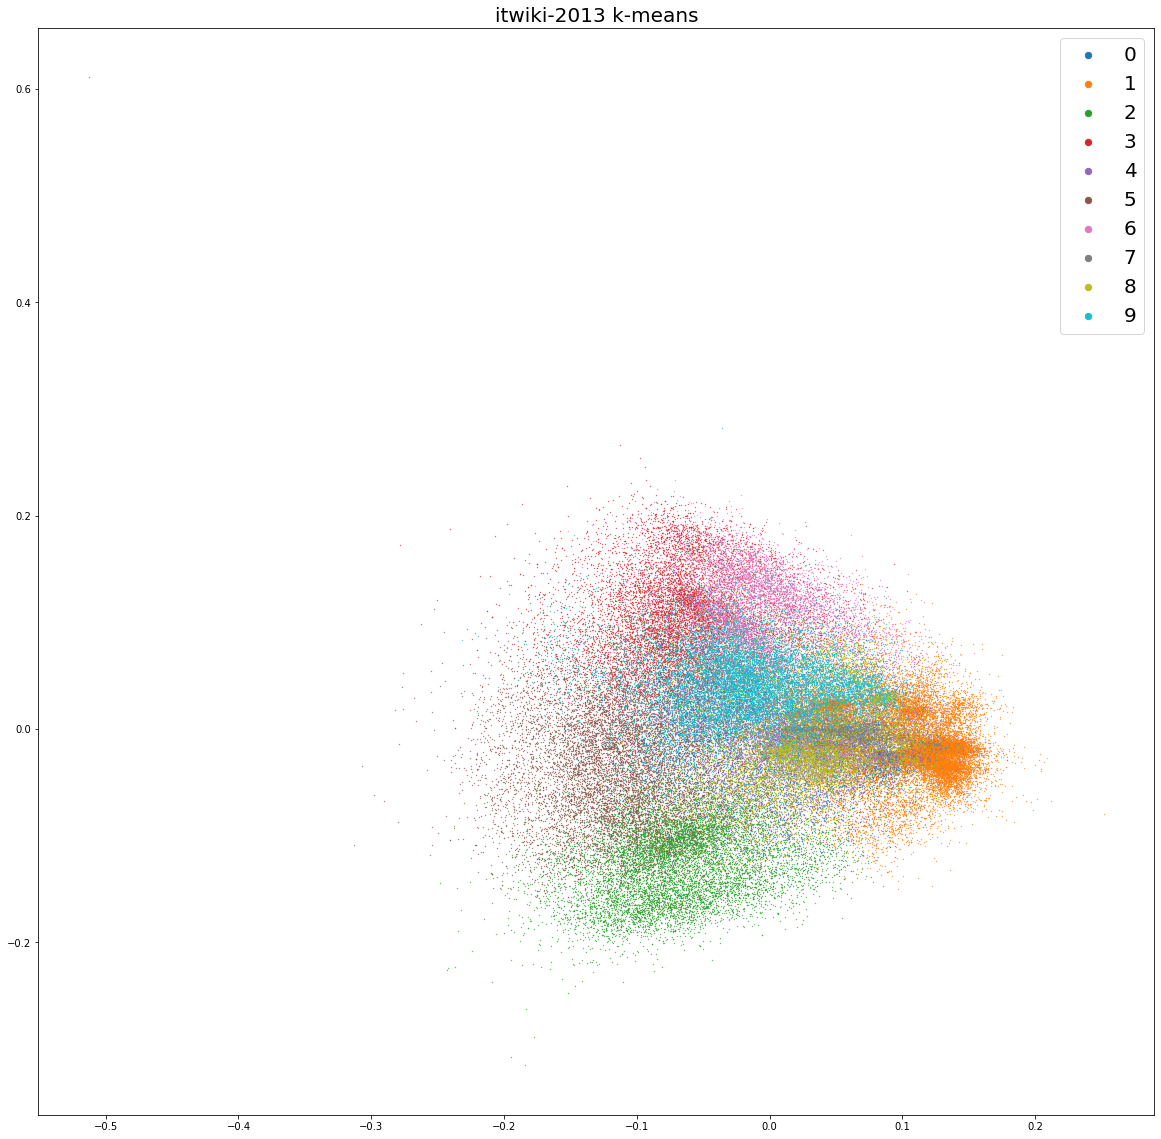

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
from utils.faiss_utils import kmeans, PCA


itwiki_kmeans = kmeans(X, 10)
itwiki_pca = PCA(X)
D, I = itwiki_kmeans.index.search(X, 1)
plot_data(itwiki_pca, I, title="itwiki-2013 k-means")

In [ ]:
import faiss


def centroid_neigh(basename, k_means, X, n=15):
    """
    Find the n-nearest neighbours to k-means
    cluster centroids.
    """
    d = X.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(X)
    D, I = index.search(k_means.centroids, n)
    entities = get_entities_list(basename)
    print(entities[:10])
    find_neighbours(basename, I, entities)


def find_neighbours(basename, idx, entities):
    """
    Helper function for centroid_neigh.
    """
    urls_file = Path('/data/graphs/') / basename / (basename + '.ids')
    f = urls_file.as_posix()
    for pos, cluster in enumerate(idx):
        print("\x1b[0;35;43m Cluster {} \x1b[0m".format(pos))
        for node in cluster:
            line = entities[node]
            print(linecache.getline(f, line + 1), entities[node])

# Clustering on partitions

Doesn't make sense..

In [52]:
centroid_neigh("itwiki-2013", itwiki_kmeans, X, n=10)

[356488, 807001, 198449, 433841, 103345, 420763, 893223, 329594, 669665, 199764]
 Cluster 0 
Selvino
 552336
Saint-Maurice-la-Clouère
 16069
Katty Line
 952014
Delle Piane (cognome)
 516096
Union Live
 831768
Champillon
 32289
Francobolli sammarinesi
 985387
Microsoft Office 2000
 1002388
Spagna preromana
 263133
Raul Boesel
 992944
 Cluster 1 
XXX Legislatura del Regno d'Italia
 68171
Welschenbach
 66043
Criterio di Kelly
 593349
Pavezin
 573976
Teone di Alessandria
 828287
Třibřichy
 10280
Paul Millsap
 929530
Nuraghe Lugherras
 707201
Stand Amid the Roar
 58022
Vordernberg
 653875
 Cluster 2 
Best Ed
 365055
Comunità monastica di Bose
 892428
Prêmio Machado de Assis
 681698
Gentile da Fabriano
 319989
On a Full Moon
 830717
August Wilson
 260755
Johanna Wokalek
 632106
La città perfetta
 349395
Bullhead (film)
 987285
538 (disambigua)
 264163
 Cluster 3 
Lo strano dramma del dottor Molyneux
 387708
New Basket Brindisi 2007-2008
 925656
Gabriele Pepe (tenente colonnello)
 503371
RVD


In [27]:
def compare_neigh(node, trained_ind, X, n=10):

    f = "/data/graphs/itwiki-2013/itwiki-2013.ids"
    print("ORIGINAL")
    temp = ent_list[node]
    print(linecache.getline(f, temp + 1))
    for i in nodes[temp]:
        print(linecache.getline(f, i + 1))
    
    print("EMBEDDINGS")
    _, I = trained_ind.search(X[node].reshape(1, -1), n)
    print(linecache.getline(f, ent_list[node] + 1))
    for i in I.flatten():
        line = ent_list[i] + 1
        print(linecache.getline(f, line))
        

In [29]:
compare_neigh(0, ind, X)

ORIGINAL
Platinum Dunes

2013

Non aprite quella porta (film 2003)

Non aprite quella porta - L'inizio

Suda e cresci

Il mai nato

Michael Bay

Film

Los Angeles

2001

Amityville Horror (film 2005)

Novembre

The Horsemen

The Hitcher (film 2007)

Nightmare (film 2010)

Venerdì 13 (film 2009)

EMBEDDINGS
Platinum Dunes

Platinum Dunes

Orzale

Australian Men's Hardcourt Championships 1997 - Doppio

Phanias

Generazione perfetta

La figlia del mio capo

Ossario italiano di Crimea

Atmosfera tecnica

Movie 43

Diga di Egschi



In [31]:
f = "/data/graphs/itwiki-2013/itwiki-2013.ids"
_, I = ind.search(X[0].reshape(1, -1), 10)
print(linecache.getline(f, ent_list[0] + 1))
for i in I.flatten():
    line = ent_list[i] + 1
    print(linecache.getline(f, line))

Platinum Dunes

Platinum Dunes

Orzale

Australian Men's Hardcourt Championships 1997 - Doppio

Phanias

Generazione perfetta

La figlia del mio capo

Ossario italiano di Crimea

Atmosfera tecnica

Movie 43

Diga di Egschi



# Using only first partition

In [54]:
model_path = Path("/data/models") / basename
with (model_path / "entity_names_link_0.json").open() as tf:
    entities_list = json.load(tf)
hf_path = list(model_path.glob("embeddings_link_0*.h5"))[0]
hf = h5py.File(hf_path)
x = hf["embeddings"][:]
idx = train_search(x)
_, I = idx.search(x[0].reshape(1, -1), 20)
for i in I.flatten():
    line = int(entities_list[i]) + 1
    print(linecache.getline(f, line))

Index trained: True
Index total: 101618
Platinum Dunes

Generazione perfetta

La figlia del mio capo

Movie 43

Big Mama - Tale padre, tale figlio

The Roommate - Il terrore ti dorme accanto

Il gatto... e il cappello matto

Gigolò per sbaglio

After.Life

David Twohy

Ti presento Bill

The Boondock Saints 2 - Il giorno di Ognissanti

Chestnut - Un eroe a quattro zampe

Accerchiato

Best Men - Amici per la pelle

The Weinstein Company

MTV Movie Awards 2002

One for the Money

Cenerentola e gli 007 nani

Ho rapito Sinatra



In [60]:
itwiki_kmeans = kmeans(x, 5, niter=100)

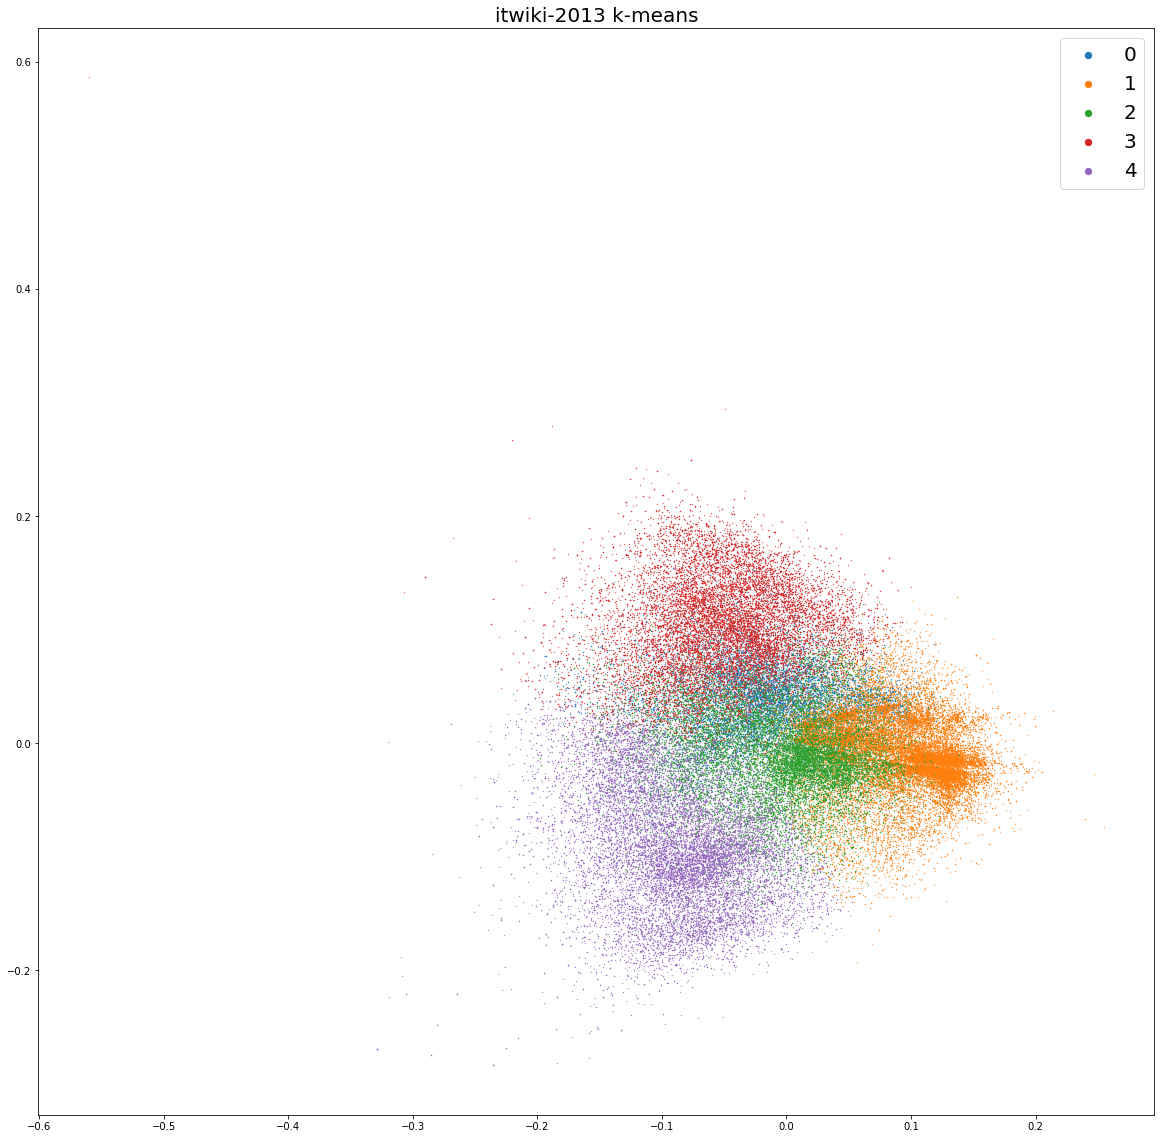

In [35]:
itwiki_pca = PCA(x)
D, I = itwiki_kmeans.index.search(x, 1)
plot_data(itwiki_pca, I, title="itwiki-2013 k-means")

In [61]:
centroid_neigh("itwiki-2013", itwiki_kmeans, x, n=10)

[356488, 807001, 198449, 433841, 103345, 420763, 893223, 329594, 669665, 199764]
 Cluster 0 
Union Live
 831768
Abbazia di Saint-Génis-des-Fontaines
 465056
Rubenow
 514210
Miniac-sous-Bécherel
 14601
Forbidden Warrior
 156756
Episodi di South Park (nona stagione)
 577673
Dipartimento del Cimino
 365200
Mō Ichi do...
 91225
Duracel
 718450
Censimento generale della popolazione e delle abitazioni
 917672
 Cluster 1 
Nuraghe Lugherras
 707201
Ebersbach
 81357
Framework
 1002986
Dolcinópolis
 694442
X-Over
 624688
The Third Day
 51554
7163 Barenboim
 59215
Il gioco della verità (film 1974)
 860649
Cosentini (Santa Venerina)
 466400
Il trono di legno
 796154
 Cluster 2 
Johanna Wokalek
 632106
Giovanni del Gaizo
 277923
Marcello Catalano
 935565
Lamine Ben Aziza
 910616
Kętrzyn
 675415
Stratford (New Hampshire)
 757283
ASM-135 ASAT
 272785
Glenwood
 375994
Borce Atanasovski
 144284
Alt Maestrat
 136
 Cluster 3 
RVD
 468971
Vicente Arraya
 551465
CUM
 917639
Saponara (disambigua)
 466716
Gi

In [62]:
ent_list[:10]

[375341,
 664430,
 728407,
 16627,
 716009,
 807080,
 1011428,
 230978,
 426862,
 381918]

In [65]:
node_id = 93120
_, I = idx.search(x[node_id].reshape(1, -1), 20)
print(I)
for i in I.flatten():
    line = int(entities_list[i]) + 1
    print(linecache.getline(f, line))

[[93120 84029 50561 64850 60225 21310 52803 52834 37671 99375 65831 51303
  75691 49521 63805 14964  3081 16462 87148  4813]]
Park Sung-Wha

Lee Tae-Ho

Fareed Majeed

Corneliu Papură

Rafael Bastos

Takashi Inui

Zaza Janashia

Giorgi Navalovsk'i

Cho Young-Jeung

Ali Samereh

El Arbi Hillel Soudani

Augusto Pacheco Fraga

Davy Schollen

Gerard Plessers

Fousseni Diawara

Kevin Betsy

Ned Zelić

Roman Šiškin

Makhete Diop

Dimitri Foulquier



In [48]:
node_id = 93120
_, I = idx.search(x[node_id].reshape(1, -1), 20)
print(I)
for i in I.flatten():
    line = ent_list[i] + 1
    print(linecache.getline(f, line))

[[93120 84029 50561 64850 60225 21310 52803 52834 37671 99375 65831 51303
  75691 49521 63805 14964  3081 16462 87148  4813]]
Park Sung-Wha

Lee Tae-Ho

Fareed Majeed

Corneliu Papură

Rafael Bastos

Takashi Inui

Zaza Janashia

Giorgi Navalovsk'i

Cho Young-Jeung

Ali Samereh

El Arbi Hillel Soudani

Augusto Pacheco Fraga

Davy Schollen

Gerard Plessers

Fousseni Diawara

Kevin Betsy

Ned Zelić

Roman Šiškin

Makhete Diop

Dimitri Foulquier

